# Face Recognition - PubFig83

**D3APL – Aplicações em Ciência de dados**

Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

# 1. Informações Gerais

## 1.1. Conhecendo  o dataset

O dataset [PubFig83](http://www.briancbecker.com/blog/research/pubfig83-lfw-dataset/) é um conjunto de dados de referência para identificação facial. O objetivo do conjunto de dados é permitir que algoritmos encontrem e identifiquem alguns indivíduos nas imagens enquanto ignoram todos os outros como rostos de fundo ou distratores. Este formato simula o que é encontrados em diversas aplicações reais, em que o reconhecimento facial precisa ignorar diversos rostos de fundo que aparecem nas fotos, mas não são relevantes aos usuários.

O dataset possui mais de 13 mil imagens que representam o rosto de 83 indivíduos famosos. Para este trabalho, todos os rostos foram previamente redimensionados para 100x100 pixels, tendo sido alinhados de acordo com a posição dos olhos das pessoas (de modo a facilitar o treinamento e reduzir o ruído das imagens). Os conjuntos de testes e treinamente foram previamente estabelecidos.

## 1.2. Objetivo

Resolver um problema de reconhecimento de faces usando redes neurais.

## 1.3. Modelos Testados

- Arquitetura definido do zero
- Arquitetura pré-definida (ResNet50)
- _Transfer Learning_ (VGG16 & ImageNet)
- Extração de característiticas (VGG19 + SVM)

# 2. Informações sobre o conjunto de dados

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import os

# Visualização de imagem
import cv2
import matplotlib.pyplot as plt

## 2.1 Carregamento dos dados

In [2]:
# Path das imagens
dataset_folder = '../Datasets'
imgs_folder = f'{dataset_folder}/imgs'

# Lista de pastas
class_folders = sorted(os.listdir(imgs_folder))
n_classes = len(class_folders)

print(f'Número de Classes: {n_classes}')

Número de Classes: 83


In [3]:
# Dataset de treino
df_train = pd.read_csv(f'{dataset_folder}/train.csv')

# Dataset de treino
df_test = pd.read_csv(f'{dataset_folder}/test.csv')

print(f'Train: {len(df_train)}')
print(f'Test: {len(df_test)}')

Train: 12178
Test: 1660


## 2.2 Visualização das imagens

In [4]:
def print_image(df, pos, dataset_folder=dataset_folder):
    img = cv2.imread(f'{dataset_folder}/{df.iloc[pos]["image_pathname"]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

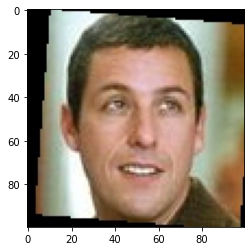

In [5]:
print_image(df_train, 5)

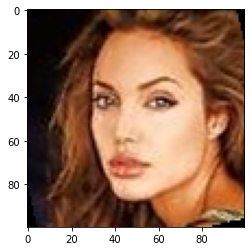

In [6]:
print_image(df_test, 50)

## 2.3 Atributos das imagens

In [7]:
def img_attrs(img_path, dataset_folder=dataset_folder):
    img = cv2.imread(f'{dataset_folder}/{img_path}')
    return [img.shape, (img.min(), img.max())]

In [8]:
attrs = df_train['image_pathname'].apply(img_attrs).apply(pd.Series)
attrs.columns = ['shape', 'colors']

attrs

,shape,colors
0,"(100, 100, 3)","(0, 255)"
1,"(100, 100, 3)","(0, 255)"
2,"(100, 100, 3)","(0, 244)"
3,"(100, 100, 3)","(0, 255)"
4,"(100, 100, 3)","(0, 255)"
...,...,...
12173,"(100, 100, 3)","(0, 236)"
12174,"(100, 100, 3)","(0, 255)"
12175,"(100, 100, 3)","(0, 255)"
12176,"(100, 100, 3)","(0, 255)"


In [9]:
attrs['shape'].unique()

array([(100, 100, 3)], dtype=object)

Todas imagens possuem o mesmo formato, de 100 x 100 x 3

In [10]:
colors_series = attrs['colors'].apply(pd.Series, dtype=np.uint8)
colors_series.min().min(), colors_series.max().max()

(0, 255)

As informações de cores variam de 0 a 255

## 2.4 Distribuição das classes

In [11]:
def images_in_class(cls, imgs_folder=imgs_folder):
    class_path = os.path.join(imgs_folder, cls)
    images = os.listdir(class_path)
    return len(images)

In [12]:
images_dict = { cls: images_in_class(cls) for cls in class_folders }
classes_images = pd.DataFrame.from_dict(images_dict, orient='index', columns=['Images'])
classes_images

,Images
Adam Sandler,108
Alec Baldwin,103
Angelina Jolie,214
Anna Kournikova,171
Ashton Kutcher,101
...,...
Uma Thurman,167
Victoria Beckham,134
Viggo Mortensen,112
Will Smith,128


In [13]:
print(f'Classe com menos imagens: {classes_images.Images.min()} imagens')
print(f'Classe com mais imagens: {classes_images.Images.max()} imagens')

Classe com menos imagens: 100 imagens
Classe com mais imagens: 367 imagens


# 3. Pré-processamento

## 3.1 Preparação dos dados

### 3.1.1 Adição de coluna com as classes nos datasets de treino e teste

In [14]:
df_train['class'] = df_train.loc[:, 'image_pathname'].str.split('/', expand=True).loc[:, 1]
df_test['class'] = df_test.loc[:, 'image_pathname'].str.split('/', expand=True).loc[:, 1]

In [15]:
df_train.sample(3)

,image_pathname,class
8653,imgs/Mickey Rourke/198.jpg,Mickey Rourke
3777,imgs/Drew Barrymore/229.jpg,Drew Barrymore
7103,imgs/Keira Knightley/483.jpg,Keira Knightley


In [16]:
df_test.sample(3)

,image_pathname,class
1047,imgs/Lindsay Lohan/145.jpg,Lindsay Lohan
386,imgs/Daniel Craig/137.jpg,Daniel Craig
1362,imgs/Robert Gates/133.jpg,Robert Gates


### 3.1.2 Criação de um dataset para validação do treinamento

In [17]:
# Dataframe com volume de amostras de treino e teste e a proporção entre eles
samples = pd.concat([df_train['class'].value_counts(), df_test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Test samples']
samples['Proportion'] = samples['Test samples'] / samples['Train samples']
samples

,Train samples,Test samples,Proportion
Miley Cyrus,347,20,0.057637
Lindsay Lohan,334,20,0.059880
Jessica Simpson,280,20,0.071429
Brad Pitt,280,20,0.071429
Avril Lavigne,279,20,0.071685
...,...,...,...
Mariah Carey,82,20,0.243902
Ashton Kutcher,81,20,0.246914
Jack Nicholson,81,20,0.246914
Robert Gates,80,20,0.250000


In [18]:
classes = df_train['class'].unique()
validation = pd.DataFrame(columns=['image_pathname', 'class'])

for cls in classes:
    cls_validation = df_train[df_train['class'] == cls].sample(20)
    validation = pd.concat([validation, cls_validation])

train = df_train.drop(index=validation.index)

test = df_test

In [19]:
samples = pd.concat([train['class'].value_counts(), validation['class'].value_counts(), test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Validation samples', 'Test samples']
samples

,Train samples,Validation samples,Test samples
Miley Cyrus,327,20,20
Lindsay Lohan,314,20,20
Jessica Simpson,260,20,20
Brad Pitt,260,20,20
Avril Lavigne,259,20,20
...,...,...,...
Mariah Carey,62,20,20
Ashton Kutcher,61,20,20
Jack Nicholson,61,20,20
Robert Gates,60,20,20


## 3.2 Undersampling dos dados de treinamento

In [20]:
n_desired_samples = 200

In [21]:
classes = df_train['class'].unique()
undersampled = pd.DataFrame(columns=['image_pathname', 'class'])

for cls in classes:
    cls_undersampled = train[train['class'] == cls].sample(frac=1)[:n_desired_samples]
    undersampled = pd.concat([undersampled, cls_undersampled])

train = undersampled

In [22]:
samples = pd.concat([train['class'].value_counts(), validation['class'].value_counts(), test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Validation samples', 'Test samples']
samples

,Train samples,Validation samples,Test samples
Jessica Simpson,200,20,20
Brad Pitt,200,20,20
Gwyneth Paltrow,200,20,20
Daniel Radcliffe,200,20,20
Katherine Heigl,200,20,20
...,...,...,...
Mariah Carey,62,20,20
Ashton Kutcher,61,20,20
Jack Nicholson,61,20,20
Robert Gates,60,20,20


In [23]:
samples.sum()

Train samples         9975
Validation samples    1660
Test samples          1660
dtype: int64

## 3.3 Pré-processamento

Carregamento dos arquivos de imagem e _feature scaling_

In [24]:
import cv2

def preprocess_dataset(dataset_df, label_encoder, dataset_folder=dataset_folder):
    image_list = []
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(f'{dataset_folder}/{img_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        image_list.append(img)
        
        # verbose - print every 1000 iterations
        if index % 1000 == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    X = np.array(image_list)
    
    # feature scaling
    X = X / 255.0
    
    # encoding the classes
    y = label_encoder.fit_transform(dataset_df['class'])
    
    return X, y

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train['class'])

LabelEncoder()

In [26]:
print('Pre-processing the training set:')
X_train, y_train = preprocess_dataset(train, label_encoder)

print('\nPre-processing the validation set:')
X_validation, y_validation = preprocess_dataset(validation, label_encoder)

print('\nPre-processing the test set:')
X_test, y_test = preprocess_dataset(test, label_encoder)

Pre-processing the training set:
1/9975 - imgs/Adam Sandler/134.jpg
1001/9975 - imgs/Beyonce Knowles/341.jpg
2001/9975 - imgs/Clive Owen/48.jpg
3001/9975 - imgs/Denise Richards/127.jpg
4001/9975 - imgs/Halle Berry/410.jpg
5001/9975 - imgs/Jessica Simpson/155.jpg
6001/9975 - imgs/Keira Knightley/291.jpg
7001/9975 - imgs/Michael Bloomberg/186.jpg
8001/9975 - imgs/Reese Witherspoon/203.jpg
9001/9975 - imgs/Silvio Berlusconi/158.jpg

Pre-processing the validation set:
1/1660 - imgs/Adam Sandler/3.jpg
1001/1660 - imgs/Kiefer Sutherland/252.jpg

Pre-processing the test set:
1/1660 - imgs/Adam Sandler/34.jpg
1001/1660 - imgs/Kiefer Sutherland/40.jpg


In [27]:
for name, X, y in [
    ('train', X_train, y_train),
    ('validation', X_validation, y_validation),
    ('test', X_test, y_test)
]:
    print(f'X_{name}.shape: {X.shape}')
    print(f'y_{name}.shape: {y.shape}')
    print(f'y_{name} ({len(np.unique(y))} classes): {np.unique(y)}')
    

    # rescaled 24-bit color image
    print(f'Min. value of X_{name}: {X.min()}')
    print(f'Max. value of X_{name}: {X.max()}\n')

X_train.shape: (9975, 100, 100, 3)
y_train.shape: (9975,)
y_train (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Min. value of X_train: 0.0
Max. value of X_train: 1.0

X_validation.shape: (1660, 100, 100, 3)
y_validation.shape: (1660,)
y_validation (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Min. value of X_validation: 0.0
Max. value of X_validation: 1.0

X_test.shape: (1660, 100, 100, 3)
y_test.shape: (1660,)
y_test (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

## 3.4 Balanceamento de classes (_data augmentation_)

In [28]:
n_samples = np.bincount(y_train)
classes = np.nonzero(n_samples)[0]

samples_per_class = list(zip(classes, n_samples))
samples_per_class[:5] # Tuples of (class, n_samples)

[(0, 68), (1, 63), (2, 174), (3, 131), (4, 61)]

In [29]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation

new_images = []
new_classes = []

# Random number generator
rng = np.random.default_rng()

# Use cpu
with tf.device('/cpu:0'):

    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(factor=0.1, fill_mode='constant'),
        # RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant')
    ])
    
    # For each class
    for (cls, n_samples) in samples_per_class:
        # Indexes of samples of current class
        cls_indexes = np.where(y_train == cls)[0]
        
        # Get n_missing_samples random samples from X_train
        n_missing_samples = n_desired_samples - n_samples

        if n_missing_samples > 0:
            random_indexes = rng.choice(cls_indexes, n_missing_samples)
            imgs = X_train[random_indexes]
        
            # Create new images
            augmented = data_augmentation(imgs)
            new_images.extend(augmented)
            new_classes.extend([cls for _ in range(n_missing_samples)])

Metal device set to: Apple M1


2022-06-26 13:21:06.495097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-26 13:21:06.495191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
arr_new_images = np.array(new_images)
X_train = np.append(X_train, arr_new_images, axis=0)
y_train = np.append(y_train, new_classes)

In [31]:
X_train.shape

(16600, 100, 100, 3)

In [32]:
y_train.shape

(16600,)

Will Smith


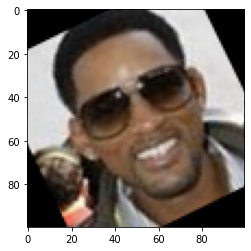

In [33]:
n = 16500
print(label_encoder.classes_[y_train[n]])
plt.imshow(X_train[n])

# 4. Modelos

In [34]:
input_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

In [35]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
def fit_model(model, optimizer, X_train, y_train, X_validation, y_validation):
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']
    
    early_stopping_patience = 10
    
    epochs = 100
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.summary()
    
    early_stopping_cb = EarlyStopping(
        patience=early_stopping_patience,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[early_stopping_cb]
    )
    
    return history

In [37]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    
    fig, axes = plt.subplots(2, figsize=(10, 10))

    history_df[['loss', 'val_loss']].plot(ax=axes[0], grid=True)
    history_df[['accuracy', 'val_accuracy']].plot(ax=axes[1], grid=True)

    plt.setp(axes, xticks=range(len(history_df)))
    plt.show()

In [38]:
def print_validation_metrics(model):
    (loss, accuracy) = model.evaluate(X_validation, y_validation)
    print('\nValidation Metrics')
    print('==================\n')
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}\n')

## 4.1 Modelo do zero

Model: "From_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 97, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 512)              

2022-06-26 13:21:17.977819: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/519 [..............................] - ETA: 3:41 - loss: 4.4003 - accuracy: 0.0312

2022-06-26 13:21:18.216680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 4.3904 - accuracy: 0.0197

2022-06-26 13:21:35.492259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 18s 34ms/step - loss: 4.3904 - accuracy: 0.0197 - val_loss: 4.3185 - val_accuracy: 0.0229
Epoch 2/100
519/519 [==============================] - 18s 34ms/step - loss: 4.0904 - accuracy: 0.0640 - val_loss: 3.9008 - val_accuracy: 0.0904
Epoch 3/100
519/519 [==============================] - 17s 33ms/step - loss: 3.6494 - accuracy: 0.1369 - val_loss: 3.5943 - val_accuracy: 0.1410
Epoch 4/100
519/519 [==============================] - 17s 33ms/step - loss: 3.1963 - accuracy: 0.2210 - val_loss: 3.1278 - val_accuracy: 0.2458
Epoch 5/100
519/519 [==============================] - 17s 33ms/step - loss: 2.6530 - accuracy: 0.3386 - val_loss: 2.9679 - val_accuracy: 0.2904
Epoch 6/100
519/519 [==============================] - 17s 33ms/step - loss: 2.1249 - accuracy: 0.4609 - val_loss: 2.5975 - val_accuracy: 0.3693
Epoch 7/100
519/519 [==============================] - 17s 33ms/step - loss: 1.6498 - accuracy: 0.5688 - val_loss: 2.5549 - val_accuracy: 0.40

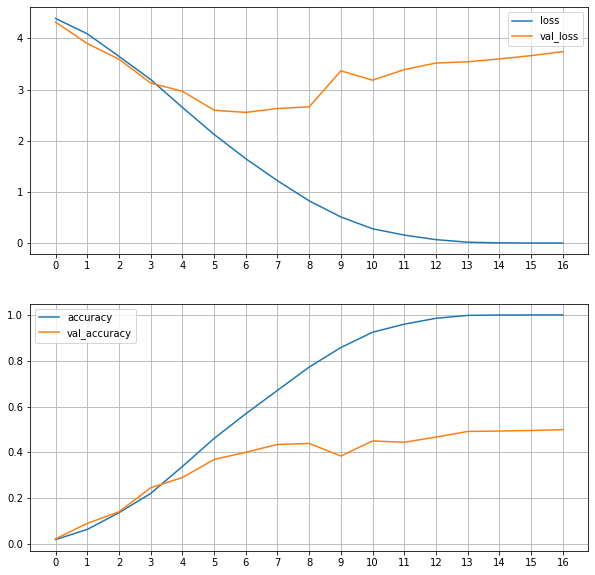

52/52 [==============================] - 1s 12ms/step - loss: 2.5549 - accuracy: 0.4006

Validation Metrics

Loss: 2.554882287979126
Accuracy: 0.40060243010520935

CPU times: user 1min 13s, sys: 1min 21s, total: 2min 35s
Wall time: 5min 17s


In [39]:
%%time

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD

model_from_scratch = Sequential([
    Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="From_Scratch")

history = fit_model(
    model=model_from_scratch,
    optimizer=SGD(),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

print_validation_metrics(model_from_scratch)

## 4.2 Utilizando uma arquitetura pré-definida (ResNet50 + NAdam)

Model: "ResNet50_without_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               16777728  
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 83)                42579     
                                                                 
Total params: 40,933,331
Trainable params:

2022-06-26 13:26:47.782593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 3.3320 - accuracy: 0.1744

2022-06-26 13:31:37.687313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 305s 527ms/step - loss: 3.3320 - accuracy: 0.1744 - val_loss: 4.4698 - val_accuracy: 0.0169
Epoch 2/100
519/519 [==============================] - 270s 520ms/step - loss: 2.0245 - accuracy: 0.4449 - val_loss: 4.3406 - val_accuracy: 0.2096
Epoch 3/100
519/519 [==============================] - 271s 521ms/step - loss: 1.3759 - accuracy: 0.6156 - val_loss: 2.1471 - val_accuracy: 0.4723
Epoch 4/100
519/519 [==============================] - 273s 525ms/step - loss: 0.9669 - accuracy: 0.7251 - val_loss: 3.2890 - val_accuracy: 0.3398
Epoch 5/100
519/519 [==============================] - 267s 514ms/step - loss: 0.6758 - accuracy: 0.8028 - val_loss: 2.4210 - val_accuracy: 0.4861
Epoch 6/100
519/519 [==============================] - 272s 525ms/step - loss: 0.5447 - accuracy: 0.8410 - val_loss: 2.0070 - val_accuracy: 0.5639
Epoch 7/100
519/519 [==============================] - 273s 526ms/step - loss: 0.4404 - accuracy: 0.8703 - val_loss: 2.2558 - val_

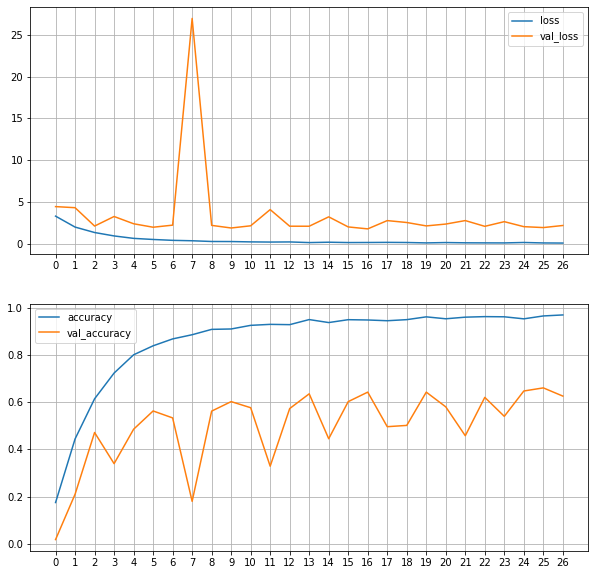

52/52 [==============================] - 5s 89ms/step - loss: 1.8095 - accuracy: 0.6440

Validation Metrics

Loss: 1.8095077276229858
Accuracy: 0.6439759135246277

CPU times: user 1h 22s, sys: 25min 14s, total: 1h 25min 37s
Wall time: 1h 59min 49s


In [40]:
%%time

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications import ResNet50

base_model_resnet50 = ResNet50(
    include_top=False,
    input_shape=input_shape
)

model_resnet50 = Sequential([
    base_model_resnet50,

    Flatten(),

    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="ResNet50_without_weights")


history = fit_model(
    model=model_resnet50,
    optimizer=Nadam(),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

print_validation_metrics(model_resnet50)

## 4.3 Transfer learning (VGG16 & ImageNet + Adam)

Model: "VGG16_with_imagenet_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1179904   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 83)                21331     
                                                                 
Total params: 15,981,715
Trainable params: 1,267,027
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100


2022-06-26 15:26:54.866214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 3.4668 - accuracy: 0.1491

2022-06-26 15:27:59.639917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 74s 137ms/step - loss: 3.4668 - accuracy: 0.1491 - val_loss: 2.9627 - val_accuracy: 0.2349
Epoch 2/100
519/519 [==============================] - 75s 144ms/step - loss: 2.4373 - accuracy: 0.3531 - val_loss: 2.5683 - val_accuracy: 0.3524
Epoch 3/100
519/519 [==============================] - 77s 148ms/step - loss: 1.9229 - accuracy: 0.4847 - val_loss: 2.4160 - val_accuracy: 0.3880
Epoch 4/100
519/519 [==============================] - 76s 146ms/step - loss: 1.5659 - accuracy: 0.5693 - val_loss: 2.3769 - val_accuracy: 0.4211
Epoch 5/100
519/519 [==============================] - 75s 145ms/step - loss: 1.2815 - accuracy: 0.6417 - val_loss: 2.3876 - val_accuracy: 0.4331
Epoch 6/100
519/519 [==============================] - 79s 152ms/step - loss: 1.0530 - accuracy: 0.6997 - val_loss: 2.5223 - val_accuracy: 0.4259
Epoch 7/100
519/519 [==============================] - 79s 153ms/step - loss: 0.8872 - accuracy: 0.7419 - val_loss: 2.7093 - val_accurac

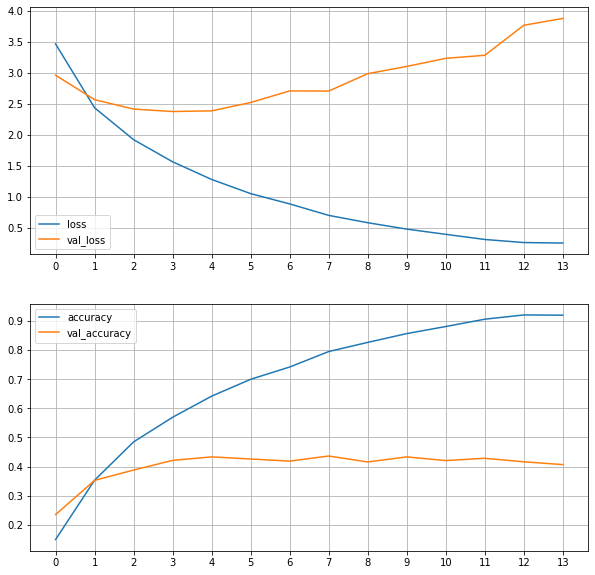

52/52 [==============================] - 6s 118ms/step - loss: 2.3769 - accuracy: 0.4211

Validation Metrics

Loss: 2.376943349838257
Accuracy: 0.42108434438705444

CPU times: user 2min 9s, sys: 4min 4s, total: 6min 13s
Wall time: 18min 44s


In [41]:
%%time

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

base_model_vgg16_imagenet = VGG16(
    include_top=None,
    weights="imagenet",
    input_shape=input_shape
)
base_model_vgg16_imagenet.trainable = False

model_vgg16_imagenet = Sequential([
    base_model_vgg16_imagenet,

    Flatten(),

    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="VGG16_with_imagenet_weights")

history = fit_model(
    model=model_vgg16_imagenet,
    optimizer=Adam(),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

print_validation_metrics(model_vgg16_imagenet)

## 4.4 Extração de features com VGG19 + SVM

In [42]:
%%time

from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG19

base_model_vgg19_imagenet = VGG19(
    include_top=None,
    weights="imagenet",
    input_shape=input_shape
)
base_model_vgg19_imagenet.trainable = False

model_vgg19_imagenet = Sequential([
    base_model_vgg19_imagenet,
    Flatten()
], name="VGG19_Feat_Extractor")

X_train_extracted = model_vgg19_imagenet.predict(X_train)
X_validation_extracted = model_vgg19_imagenet.predict(X_validation)

2022-06-26 15:45:15.015199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 8s 149ms/step
CPU times: user 6.77 s, sys: 15.3 s, total: 22.1 s
Wall time: 1min 41s


In [43]:
%%time

from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

svm = LinearSVC(C=0.01)
svm.fit(X_train_extracted, y_train)

y_validation_pred = svm.predict(X_validation_extracted)

print(classification_report(y_validation, y_validation_pred, output_dict=True)['accuracy'])

0.48975903614457833
CPU times: user 2min 38s, sys: 670 ms, total: 2min 39s
Wall time: 2min 39s


# 5. Testes

In [44]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

## 5.1 Modelo do zero

In [45]:
model_from_scratch.evaluate(X_test, y_test)

52/52 [==============================] - 1s 13ms/step - loss: 2.4586 - accuracy: 0.4205


[2.458592176437378, 0.42048195004463196]

In [46]:
y_test_proba = model_from_scratch.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

 3/52 [>.............................] - ETA: 1s 

2022-06-26 15:49:30.097878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 1s 13ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.44      0.55      0.49        20
        Alec Baldwin       0.55      0.30      0.39        20
      Angelina Jolie       0.19      0.30      0.24        20
     Anna Kournikova       0.50      0.40      0.44        20
      Ashton Kutcher       0.60      0.30      0.40        20
       Avril Lavigne       0.50      0.40      0.44        20
        Barack Obama       0.86      0.60      0.71        20
         Ben Affleck       0.31      0.20      0.24        20
     Beyonce Knowles       0.37      0.35      0.36        20
           Brad Pitt       0.25      0.15      0.19        20
        Cameron Diaz       0.16      0.30      0.21        20
      Cate Blanchett       0.40      0.10      0.16        20
     Charlize Theron       0.32      0.35      0.33        20
     Christina Ricci       0.88      0.35      0.50        20
    Claudia Sch

## 5.2 ResNet50

In [47]:
model_resnet50.evaluate(X_test, y_test)

52/52 [==============================] - 5s 89ms/step - loss: 1.9390 - accuracy: 0.6373


[1.9389888048171997, 0.6373494267463684]

In [48]:
y_test_proba = model_resnet50.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

2022-06-26 15:49:36.527529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 6s 97ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.90      0.45      0.60        20
        Alec Baldwin       0.75      0.60      0.67        20
      Angelina Jolie       0.73      0.55      0.63        20
     Anna Kournikova       0.57      0.65      0.60        20
      Ashton Kutcher       0.62      0.50      0.56        20
       Avril Lavigne       0.54      0.70      0.61        20
        Barack Obama       0.88      0.75      0.81        20
         Ben Affleck       0.94      0.75      0.83        20
     Beyonce Knowles       0.92      0.55      0.69        20
           Brad Pitt       0.35      0.90      0.51        20
        Cameron Diaz       0.64      0.70      0.67        20
      Cate Blanchett       0.48      0.55      0.51        20
     Charlize Theron       0.29      0.55      0.38        20
     Christina Ricci       0.60      0.75      0.67        20
    Claudia Sch

## 5.3 VGG16 & ImageNet

In [49]:
model_vgg16_imagenet.evaluate(X_test, y_test)

52/52 [==============================] - 6s 116ms/step - loss: 2.3969 - accuracy: 0.3964


[2.396918773651123, 0.3963855504989624]

In [50]:
y_test_proba = model_vgg16_imagenet.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

 1/52 [..............................] - ETA: 10s

2022-06-26 15:49:48.753812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 6s 117ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.60      0.60      0.60        20
        Alec Baldwin       0.67      0.30      0.41        20
      Angelina Jolie       0.20      0.35      0.25        20
     Anna Kournikova       0.50      0.05      0.09        20
      Ashton Kutcher       0.54      0.35      0.42        20
       Avril Lavigne       0.50      0.20      0.29        20
        Barack Obama       0.68      0.65      0.67        20
         Ben Affleck       0.33      0.55      0.42        20
     Beyonce Knowles       0.50      0.30      0.37        20
           Brad Pitt       0.12      0.15      0.13        20
        Cameron Diaz       0.35      0.35      0.35        20
      Cate Blanchett       0.18      0.25      0.21        20
     Charlize Theron       0.26      0.30      0.28        20
     Christina Ricci       0.38      0.25      0.30        20
    Claudia Sc

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

## 5.4 VGG19 + SVM

In [51]:
X_test_extracted = model_vgg19_imagenet.predict(X_test)
y_test_pred = svm.predict(X_test_extracted)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

52/52 [==============================] - 7s 134ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.65      0.55      0.59        20
        Alec Baldwin       0.85      0.55      0.67        20
      Angelina Jolie       0.33      0.45      0.38        20
     Anna Kournikova       0.33      0.30      0.32        20
      Ashton Kutcher       0.36      0.25      0.29        20
       Avril Lavigne       0.63      0.85      0.72        20
        Barack Obama       0.52      0.70      0.60        20
         Ben Affleck       0.58      0.35      0.44        20
     Beyonce Knowles       0.50      0.35      0.41        20
           Brad Pitt       0.23      0.35      0.28        20
        Cameron Diaz       0.35      0.40      0.37        20
      Cate Blanchett       0.33      0.30      0.32        20
     Charlize Theron       0.21      0.20      0.21        20
     Christina Ricci       0.39      0.35      0.37        20
    Claudia Sc